**Gesture Recognition Live Project:**

1.   This project involves processing videos of 30 frames each for doing Gesture recognition for smart TV. 
2.   Images are from two sources where the dimensions are (120,160,3) and (360,360,3)
3. Each Video is tagged with a gesture name amongst the five gesture names.
    - Thumbs up:  Increase the volume
    - Thumbs down: Decrease the volume
    - Left swipe: 'Jump' backwards 10 seconds
    - Right swipe: 'Jump' forward 10 seconds  
    - Stop: Pause the movie

**Team Members:**
- Omkaar Joshi 
- Sameer Gadicherla

**Batch:** March 2021

In [ ]:
!pip install scipy==1.1.0

In [ ]:
## importing the necessary libraries
import numpy as np
import os
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import datetime
import abc
from abc import ABCMeta

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K

# %tensorflow_version 1.5
import tensorflow as tf
tf.compat.v1.set_random_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D , Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.applications import mobilenet
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau ,EarlyStopping
from keras import optimizers

In [ ]:
##lets take a look at the configuration
!nvidia-smi

Tue Oct 26 09:19:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
##mount the drive to get the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Get the dataset to the colab runtime local memory
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('gesture_recognition.zip')

In [ ]:
!unzip /content/gesture_recognition.zip

Archive:  /content/gesture_recognition.zip
replace Project_data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#defining the project folder path
project_folder_path = "/content/Project_data"

ModelClass:
- This model class will handle all the initialisations of paths, image properties and model properties
- This class will have a generator function as well for generating the data with labels
  - The images will be cropped to the size we want
  - The images with irregular dimension will be center cropped on the x-axis equally on both sides
  - We save the model only when the validation loss decreases
  - Learning rate decreases when approaching the minima
- This class will have an abstract method to define our own model by inheriting this class
- This class will have a generic train function as well.
- The history is saved to plot the model as well


In [ ]:
class ModelClass(metaclass= ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder_path):
        self.train_doc = np.random.permutation(open(project_folder_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder_path + '/' + 'val.csv').readlines())
        self.train_path = project_folder_path + '/' + 'train'
        self.val_path =  project_folder_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties    
    def initialize_image_properties(self,image_height=120,image_width=120):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=32,num_epochs=50):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    def initialize_modelparams(self):
        self.model = None
        self.history = None

    def generator(self,source_path, folder_list, model_type = "Conv3D"):
      if model_type == "Conv3D":
        img_idx = [rn.randint(0, self.total_frames-1) for i in range(self.frames_to_sample)] #create a list of image numbers you want to use for a particular video
      else:
        img_idx = [i for i in range(self.frames_to_sample)] ## CNN+GRU
      # print(img_idx)
      while True:
          t = np.random.permutation(folder_list)
          num_batches = len(folder_list)//self.batch_size # calculate the number of batches
          for batch_no in range(num_batches): # we iterate over the number of batches
              batch_data = np.zeros((self.batch_size,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
              batch_labels = np.zeros((self.batch_size,self.num_classes)) # batch_labels is the one hot representation of the output
              for folder in range(self.batch_size): # iterate over the batch_size
                  imgs = os.listdir(source_path+'/'+ t[folder + (batch_no*self.batch_size)].split(';')[0]) # read all the images in the folder
                  # print("imgs: ",imgs)
                  for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                      image = imread(source_path+'/'+ t[folder + (batch_no*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape == (360,360,3): ###if images are of 360 x 360
                        image = imresize(image,(self.image_height,self.image_width,self.channels))
                      else:
                        image = image[:,(image.shape[0] - self.image_height ) // 2 : image.shape[0] - (image.shape[0] - self.image_height ) // 2] ### if lower quality just centre crop
                      #crop the images and resize them. Note that the images are of 2 different shape 
                      #and the conv3D will throw error if the inputs in a batch have different shapes
                      

                      batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                      
                  batch_labels[folder, int(t[folder + (batch_no*self.batch_size)].strip().split(';')[2])] = 1
              yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

          
      #     write the code for the remaining data points which are left after full batches
          left_images = len(folder_list)%self.batch_size
          left_overs = t[len(t)-left_images:]

          batch_data = np.zeros((left_images,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((left_images,self.num_classes)) # batch_labels is the one hot representation of the output
          for folder in range(left_images): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ left_overs[folder].split(';')[0]) # read all the images in the folder
              # print("imgs: ",imgs)
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imread(source_path+'/'+ left_overs[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  if image.shape == (360,360,3): ###if images are of 360 x 360
                        image = imresize(image,(self.image_height,self.image_width,self.channels))
                  else:
                    image = image[:,(image.shape[0] - self.image_height ) // 2 : image.shape[0] - (image.shape[0] - self.image_height ) // 2] ### if lower quality just centre crop
                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                  

                  batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                  
              batch_labels[folder, int(left_overs[folder].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    @abc.abstractmethod
    def model_architecture(self):
      pass

    def train_model(self,model,model_name="model_init",model_type="Conv3D"):
        train_generator = self.generator(self.train_path, self.train_doc,model_type=model_type)
        val_generator = self.generator(self.val_path, self.val_doc,model_type=model_type)

        model_name = model_name + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = "/content/drive/MyDrive/"+model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        # earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        self.history = history
        return history

    def plot_model(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

**Sample Image cropping is shown below**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(120, 160, 3)


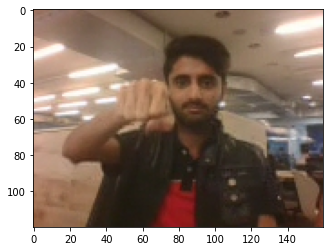

In [ ]:
##actual image
image = imread('/content/drive/MyDrive/Project_data/train/WIN_20180925_17_44_57_Pro_Thumbs_Down_new/WIN_20180925_17_44_57_Pro_00015.png')
print(image.shape)
plt.imshow(image/255)


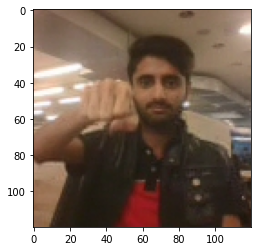

In [ ]:
##centre cropping of the image looks like this for a (120,160) image
image = image[:,20:140]
plt.imshow(image)
plt.show()

## Model Building

**Approach 1:** Conv3D model

Lets write base model which has Conv3D + BatchNorm + MaxPooling3D layers lined up with a softmax at the end

In [ ]:
class Conv3D1(ModelClass):
    
    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Model 1:** Conv3D model with 
- just 15 frames to be sampled 
- batch size of 32
- Images cropped to 120,120
- 128 dense neurons in the two dense layers

In [ ]:
conv3D1 = Conv3D1()
conv3D1.initialize_path(project_folder_path)
conv3D1.initialize_image_properties(image_height=120,image_width=120)
conv3D1.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=20)
conv3D1.initialize_modelparams()
conv3D1_model=conv3D1.model_architecture(dense_neurons=128,dropout=0.25)
conv3D1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
activation_17 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 60, 60, 32)    

In [ ]:
##train the model
conv3D1.train_model(conv3D1_model,model_name="conv3D1",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
19/21 [==========================>...] - ETA: 3s - loss: 1.4605 - categorical_accuracy: 0.4556

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 50s 2s/step - loss: 1.4456 - categorical_accuracy: 0.4691 - val_loss: 2.4308 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.43084, saving model to /content/drive/MyDrive/conv3D1_2021-10-2518_32_20.663477/model-00001-1.44557-0.46908-2.43084-0.16000.h5
Epoch 2/20
21/21 [==============================] - 47s 2s/step - loss: 0.8308 - categorical_accuracy: 0.6802 - val_loss: 4.4203 - val_categorical_accuracy: 0.1200

Epoch 00002: val_loss did not improve from 2.43084
Epoch 3/20
21/21 [==============================] - 46s 2s/step - loss: 0.5538 - categorical_accuracy: 0.7919 - val_loss: 5.0598 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 2.43084
Epoch 4/20
21/21 [==============================] - 47s 2s/step - loss: 0.3575 - categorical_accuracy: 0.8824 - val_loss: 6.6174 - val_categorical_accuracy: 0.1600

Epoch 00004: val_loss did not improve from 2.43084
Epoch 5/20
21/21 [========

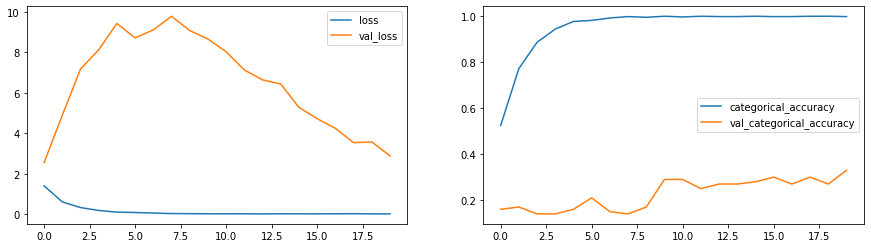

In [ ]:
# plot the model
conv3D1.plot_model()

**Observations and Thoughts:**


1.   Clearly overfitting with val accuracy just being around 30% and train accuracy reaching 99%+
2.   Let's decrease the batch_size to reduce generalisability and increase the epochs and also increase the frames to sample






**Model 2:** Conv3D model with 
- 20 frames to be sampled 
- batch size of 20
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 30

In [ ]:
conv3D2 = Conv3D1()
conv3D2.initialize_path(project_folder_path)
conv3D2.initialize_image_properties(image_height=120,image_width=120)
conv3D2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv3D2.initialize_modelparams()
conv3D2_model=conv3D2.model_architecture(dense_neurons=128,dropout=0.25)
conv3D2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    1

In [ ]:
##train the model
conv3D2.train_model(conv3D2_model,model_name="conv3D2",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/30
19/21 [==========================>...] - ETA: 4s - loss: 0.1104 - categorical_accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 59s 3s/step - loss: 0.1100 - categorical_accuracy: 0.9698 - val_loss: 3.5303 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 3.53029, saving model to /content/drive/MyDrive/conv3D2_2021-10-2518_56_42.188801/model-00001-0.11004-0.96983-3.53029-0.27000.h5
Epoch 2/30
21/21 [==============================] - 59s 3s/step - loss: 0.0898 - categorical_accuracy: 0.9910 - val_loss: 3.2344 - val_categorical_accuracy: 0.2800

Epoch 00002: val_loss improved from 3.53029 to 3.23438, saving model to /content/drive/MyDrive/conv3D2_2021-10-2518_56_42.188801/model-00002-0.08979-0.99095-3.23438-0.28000.h5
Epoch 3/30
21/21 [==============================] - 65s 3s/step - loss: 0.0986 - categorical_accuracy: 0.9940 - val_loss: 2.7454 - val_categorical_accuracy: 0.3100

Epoch 00003: val_loss improved from 3.23438 to 2.74539, saving model to /content/drive/MyDrive/conv3D2_2021-10-2518_56_42.188801/model-00003-0.09861-0.99397-2.74539-0.3

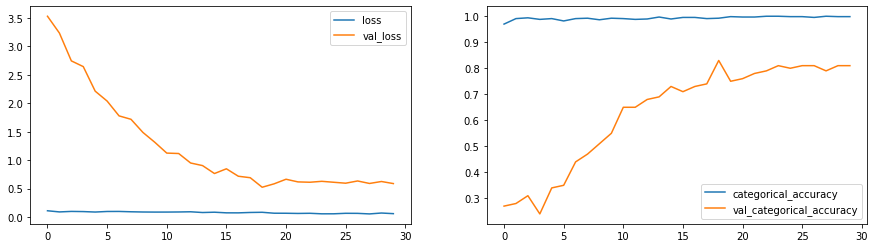

In [ ]:
conv3D2.plot_model()

**Observations and Thoughts:**


1.   we have pushed the validation accuracy by a large extent from 20% to 83%
2.   We still see there is some gap between training and testing accuracy which is around 15% where training accuracy is 99%
3. We should try increasing dropout and decrease batch_size to see if it reduces the gap
4. Still this model is decent after 19th epoch with loss: 0.0832 - categorical_accuracy: 0.9925 - val_loss: 0.5237 - val_categorical_accuracy: 0.8300. The losses are below 1


**Model 3:** Conv3D model with 
- 20 frames to be sampled 
- batch size of 16 (perviously 20)
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 30
- dropout = 0.5






In [ ]:
conv3D3 = Conv3D1()
conv3D3.initialize_path(project_folder_path)
conv3D3.initialize_image_properties(image_height=120,image_width=120)
conv3D3.initialize_hyperparams(frames_to_sample=20,batch_size=16,num_epochs=30)
conv3D3.initialize_modelparams()
conv3D3_model=conv3D3.model_architecture(dense_neurons=128,dropout=0.5)
conv3D3_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_32 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_33 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 10, 60, 60, 32)   

In [ ]:
#train the model
conv3D3.train_model(conv3D3_model,model_name="conv3D3",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/30
40/42 [===========================>..] - ETA: 2s - loss: 1.8741 - categorical_accuracy: 0.3688

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


41/42 [============================>.] - ETA: 1s - loss: 1.8870 - categorical_accuracy: 0.3659

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 71s 2s/step - loss: 1.8801 - categorical_accuracy: 0.3695 - val_loss: 4.2742 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 4.27416, saving model to /content/drive/MyDrive/conv3D3_2021-10-2519_39_16.648132/model-00001-1.88009-0.36953-4.27416-0.16000.h5
Epoch 2/30
42/42 [==============================] - 59s 1s/step - loss: 1.3757 - categorical_accuracy: 0.4902 - val_loss: 6.8100 - val_categorical_accuracy: 0.1300

Epoch 00002: val_loss did not improve from 4.27416
Epoch 3/30
42/42 [==============================] - 59s 1s/step - loss: 1.1591 - categorical_accuracy: 0.5867 - val_loss: 6.7836 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 4.27416
Epoch 4/30
42/42 [==============================] - 58s 1s/step - loss: 1.1252 - categorical_accuracy: 0.6033 - val_loss: 8.8914 - val_categorical_accuracy: 0.1800

Epoch 00004: val_loss did not improve from 4.27416
Epoch 5/30
42/42 [========

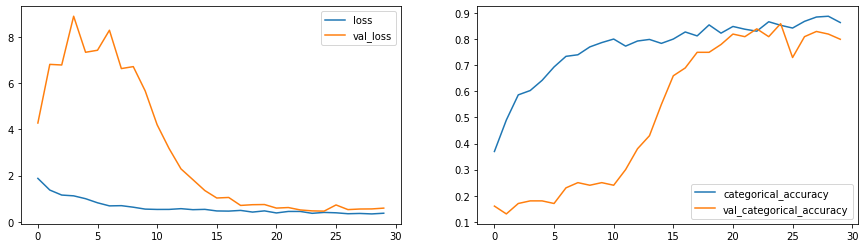

In [ ]:
conv3D3.plot_model()

**Observations and Thoughts:**


1. We have now reduced the gap between training and validation accuracy, thereby completely **overcoming overfitting**.
2. We see that least validation loss is at 0.4635 
3. The post 25th epoch had loss: 0.4083 - categorical_accuracy: 0.8537 - val_loss: 0.4636 - val_categorical_accuracy: 0.8600
4. We see that the training accuracy is lesser than the validation accuracy. 
  - This happens when the validation set is easier to interpret than the training set. 
  - This is **NOT** a negative sign and is much realistic as you see that the training and validation loss are very close by similar to categorical accuracies. 
5. Let's try a few more models like above using different kernel size to see if we see some more improvement  

**Model 4:** Conv3D model with 
- 15 frames to be sampled 
- batch size of 32 
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- kernel size = (3,3,3)






In [ ]:
class Conv3D4(ModelClass):
    
    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3D4 = Conv3D4()
conv3D4.initialize_path(project_folder_path)
conv3D4.initialize_image_properties(image_height=120,image_width=120)
conv3D4.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=20)
conv3D4.initialize_modelparams()
conv3D4_model=conv3D4.model_architecture(dense_neurons=128,dropout=0.25)
conv3D4_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 60, 60, 32)     1

In [ ]:
conv3D4.train_model(conv3D4_model,model_name="conv3D4",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
19/21 [==========================>...] - ETA: 3s - loss: 1.6907 - categorical_accuracy: 0.3684

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 78s 2s/step - loss: 1.6657 - categorical_accuracy: 0.3786 - val_loss: 1.5951 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 1.59512, saving model to /content/drive/MyDrive/conv3D4_2021-10-2519_08_54.644943/model-00001-1.66574-0.37858-1.59512-0.33000.h5
Epoch 2/20
21/21 [==============================] - 45s 2s/step - loss: 1.0562 - categorical_accuracy: 0.6063 - val_loss: 2.6377 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.59512
Epoch 3/20
21/21 [==============================] - 44s 2s/step - loss: 0.8625 - categorical_accuracy: 0.6621 - val_loss: 2.1944 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.59512
Epoch 4/20
21/21 [==============================] - 45s 2s/step - loss: 0.6446 - categorical_accuracy: 0.7436 - val_loss: 2.5369 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 1.59512
Epoch 5/20
21/21 [========

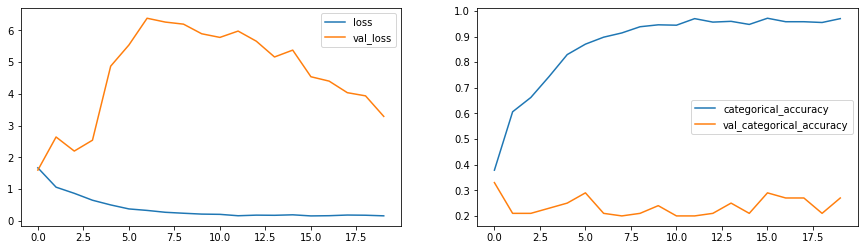

In [ ]:
conv3D4.plot_model()

**Observations and Thoughts:**


1. A case of complete overfitting is seen here.
2. Lets reduce the batch size

**Model 5:** Conv3D model with 
- 15 frames to be sampled 
- batch size of 20
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- kernel size = (3,3,3)

In [ ]:
conv3D5 = Conv3D4()
conv3D5.initialize_path(project_folder_path)
conv3D5.initialize_image_properties(image_height=120,image_width=120)
conv3D5.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=20)
conv3D5.initialize_modelparams()
conv3D5_model=conv3D5.model_architecture(dense_neurons=128,dropout=0.25)
conv3D5_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 60, 60, 32)    

In [ ]:
conv3D5.train_model(conv3D5_model,model_name="conv3D5",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
32/34 [===========================>..] - ETA: 2s - loss: 1.5888 - categorical_accuracy: 0.4422

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


34/34 [==============================] - 44s 1s/step - loss: 1.5774 - categorical_accuracy: 0.4449 - val_loss: 1.5509 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 1.55090, saving model to /content/drive/MyDrive/conv3D5_2021-10-2519_27_06.897930/model-00001-1.57741-0.44495-1.55090-0.33000.h5
Epoch 2/20
32/34 [===========================>..] - ETA: 2s - loss: 1.3710 - categorical_accuracy: 0.4500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 42s 1s/step - loss: 1.3782 - categorical_accuracy: 0.4465 - val_loss: 4.0283 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.55090
Epoch 3/20
34/34 [==============================] - 42s 1s/step - loss: 1.0267 - categorical_accuracy: 0.5973 - val_loss: 5.6085 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.55090
Epoch 4/20
34/34 [==============================] - 42s 1s/step - loss: 0.8222 - categorical_accuracy: 0.6817 - val_loss: 4.4446 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 1.55090
Epoch 5/20
34/34 [==============================] - 42s 1s/step - loss: 0.7317 - categorical_accuracy: 0.7134 - val_loss: 4.2454 - val_categorical_accuracy: 0.1700

Epoch 00005: val_loss did not improve from 1.55090

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
34/34 [==============================] - 42s 1s/step -

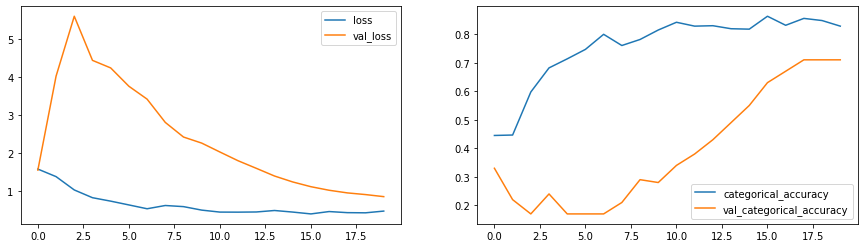

In [ ]:
conv3D5.plot_model()

**Observations and Thoughts:**


1. We have now reduced the gap between training and validation accuracy, thereby reduced **overfitting** by a large extent.
2. The validation loss is below 1 (~= 0.86)
3. The model has loss: 0.4693 - categorical_accuracy: 0.8281 - val_loss: 0.8504 - val_categorical_accuracy: 0.7100
4. The accuracies are a lot better than the previous model. Based on the graphs, lets try increasing the epochs, may be we might acheive something better.

**Model 6:** Conv3D model with 
- 15 frames to be sampled 
- batch size of 20 
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 40
- dropout = 0.25
- kernel size = (3,3,3)

In [ ]:
conv3D6 = Conv3D4()
conv3D6.initialize_path(project_folder_path)
conv3D6.initialize_image_properties(image_height=120,image_width=120)
conv3D6.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=40)
conv3D6.initialize_modelparams()
conv3D6_model=conv3D6.model_architecture(dense_neurons=128,dropout=0.25)
conv3D6_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 60, 60, 32)    

In [ ]:
conv3D6.train_model(conv3D6_model,model_name="conv3D6",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/40
32/34 [===========================>..] - ETA: 2s - loss: 1.5901 - categorical_accuracy: 0.4156

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 44s 1s/step - loss: 1.5726 - categorical_accuracy: 0.4163 - val_loss: 1.7109 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 1.71090, saving model to /content/drive/MyDrive/conv3D6_2021-10-2520_02_30.073156/model-00001-1.57257-0.41629-1.71090-0.30000.h5
Epoch 2/40
34/34 [==============================] - 42s 1s/step - loss: 1.0287 - categorical_accuracy: 0.6094 - val_loss: 5.4725 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.71090
Epoch 3/40
34/34 [==============================] - 41s 1s/step - loss: 0.9872 - categorical_accuracy: 0.6184 - val_loss: 6.3685 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.71090
Epoch 4/40
34/34 [==============================] - 41s 1s/step - loss: 0.8332 - categorical_accuracy: 0.6863 - val_loss: 6.8109 - val_categorical_accuracy: 0.1800

Epoch 00004: val_loss did not improve from 1.71090
Epoch 5/40
34/34 [========

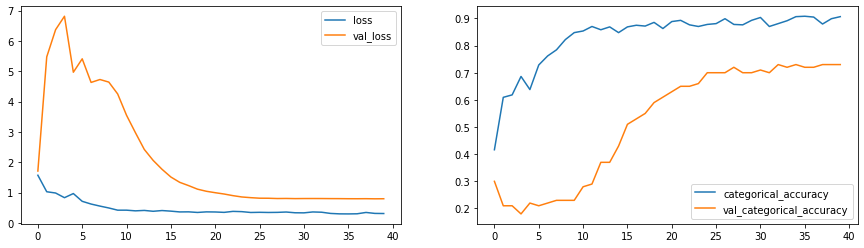

In [ ]:
conv3D6.plot_model()

**Observations and Thoughts:**


1. There is improvement in validation accuracy by 2% from 71% to 73%
2. Validation loss improved from 0.86 to 0.79



**Model 7:** Conv3D model with added convolutional layers
- 15 frames to be sampled 
- batch size of 32 
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- kernel size = (2,2,2)

In [ ]:
class Conv3D7(ModelClass):
    
    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(256, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(512, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3D7 = Conv3D7()
conv3D7.initialize_path(project_folder_path)
conv3D7.initialize_image_properties(image_height=120,image_width=120)
conv3D7.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=20)
conv3D7.initialize_modelparams()
conv3D7_model=conv3D7.model_architecture(dense_neurons=128,dropout=0.25)
conv3D7_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_35 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_35 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_35 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_36 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
activation_36 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 7, 60, 60, 32)    

In [ ]:
##train the model
conv3D7.train_model(conv3D7_model,model_name="conv3D7",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
19/21 [==========================>...] - ETA: 3s - loss: 1.7315 - categorical_accuracy: 0.3980

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 78s 2s/step - loss: 1.6907 - categorical_accuracy: 0.4042 - val_loss: 1.6400 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.63999, saving model to /content/drive/MyDrive/conv3D7_2021-10-2616_41_32.263188/model-00001-1.69069-0.40422-1.63999-0.21000.h5
Epoch 2/20
21/21 [==============================] - 43s 2s/step - loss: 1.3789 - categorical_accuracy: 0.4977 - val_loss: 1.7450 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 1.63999
Epoch 3/20
21/21 [==============================] - 43s 2s/step - loss: 1.0993 - categorical_accuracy: 0.5611 - val_loss: 1.8499 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 1.63999
Epoch 4/20
21/21 [==============================] - 40s 2s/step - loss: 0.9012 - categorical_accuracy: 0.6365 - val_loss: 1.8515 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 1.63999
Epoch 5/20
21/21 [========

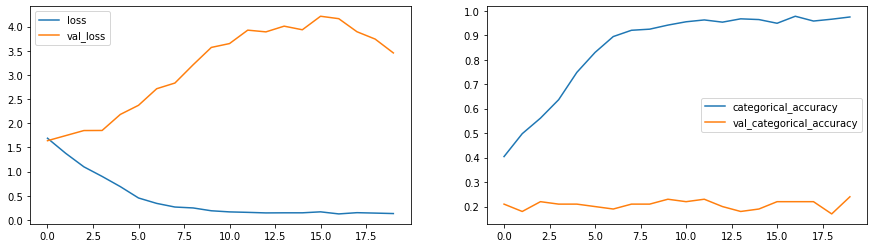

In [ ]:
# plot the model
conv3D7.plot_model()

**Observations and Thoughts:**


1.   Clearly overfitting with val accuracy just being around 24% and train accuracy reaching 97%+
2.   Let's decrease the batch_size to increase generalisability







**Model 8:** Conv3D model with added convolutional layers
- 15 frames to be sampled 
- batch size of 20 
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- kernel size = (2,2,2)

In [ ]:
conv3D8 = Conv3D7()
conv3D8.initialize_path(project_folder_path)
conv3D8.initialize_image_properties(image_height=120,image_width=120)
conv3D8.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=20)
conv3D8.initialize_modelparams()
conv3D8_model=conv3D8.model_architecture(dense_neurons=128,dropout=0.25)
conv3D8_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_49 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
activation_50 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 7, 60, 60, 32)   

In [ ]:
##train the model
conv3D8.train_model(conv3D8_model,model_name="conv3D8",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
32/34 [===========================>..] - ETA: 2s - loss: 1.8167 - categorical_accuracy: 0.3609

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 46s 1s/step - loss: 1.8108 - categorical_accuracy: 0.3650 - val_loss: 1.6834 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.68341, saving model to /content/drive/MyDrive/conv3D8_2021-10-2617_15_20.998514/model-00001-1.81077-0.36501-1.68341-0.16000.h5
Epoch 2/20
34/34 [==============================] - 41s 1s/step - loss: 1.4938 - categorical_accuracy: 0.4042 - val_loss: 1.9742 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.68341
Epoch 3/20
34/34 [==============================] - 41s 1s/step - loss: 1.3219 - categorical_accuracy: 0.4751 - val_loss: 2.1294 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.68341
Epoch 4/20
34/34 [==============================] - 40s 1s/step - loss: 1.3152 - categorical_accuracy: 0.4706 - val_loss: 3.2651 - val_categorical_accuracy: 0.1600

Epoch 00004: val_loss did not improve from 1.68341
Epoch 5/20
34/34 [========

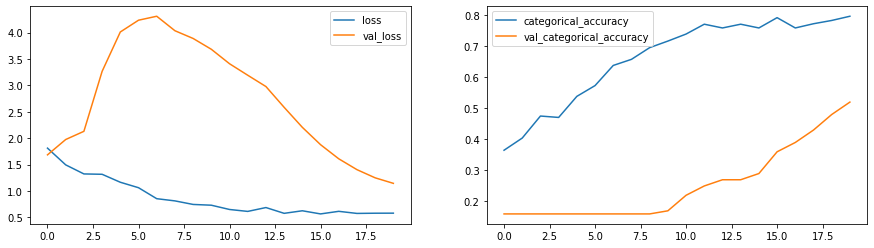

In [ ]:
conv3D8.plot_model()

**Observations and Thoughts:**


1.   Validation accuracy improved from 24% to 52%. Training accuracy decreased from 97% to 79%
2.   Let's increase the epochs to see if validation increases further







**Model 9:** Conv3D model with added convolutional layers and 40 epochs
- 15 frames to be sampled 
- batch size of 20 
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 40
- dropout = 0.25
- kernel size = (2,2,2)

In [ ]:
conv3D9 = Conv3D7()
conv3D9.initialize_path(project_folder_path)
conv3D9.initialize_image_properties(image_height=120,image_width=120)
conv3D9.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=40)
conv3D9.initialize_modelparams()
conv3D9_model=conv3D9.model_architecture(dense_neurons=128,dropout=0.25)
conv3D9_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_56 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_56 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_56 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
activation_57 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 7, 60, 60, 32)   

In [ ]:
##train the model
conv3D9.train_model(conv3D9_model,model_name="conv3D9",model_type="Conv3D")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/40
32/34 [===========================>..] - ETA: 2s - loss: 1.7426 - categorical_accuracy: 0.3875

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 48s 1s/step - loss: 1.7490 - categorical_accuracy: 0.3861 - val_loss: 1.7018 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.70180, saving model to /content/drive/MyDrive/conv3D9_2021-10-2617_48_42.948894/model-00001-1.74899-0.38612-1.70180-0.16000.h5
Epoch 2/40
34/34 [==============================] - 43s 1s/step - loss: 1.3702 - categorical_accuracy: 0.4706 - val_loss: 1.7319 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.70180
Epoch 3/40
34/34 [==============================] - 42s 1s/step - loss: 1.3410 - categorical_accuracy: 0.4992 - val_loss: 2.1273 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.70180
Epoch 4/40
34/34 [==============================] - 42s 1s/step - loss: 1.0912 - categorical_accuracy: 0.5716 - val_loss: 2.9088 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 1.70180
Epoch 5/40
34/34 [========

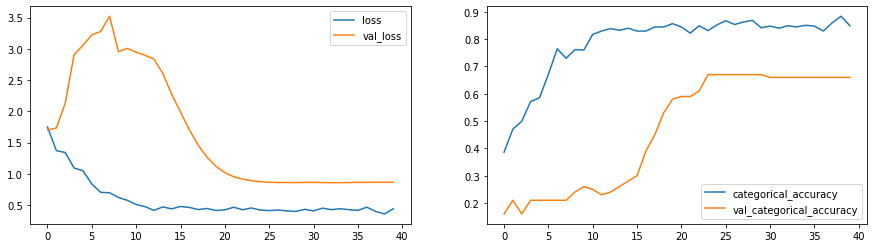

In [ ]:
conv3D9.plot_model()

**Observations and Thoughts:**


1.   Validation accuracy improved from 52% to 67%. Training accuracy increased from 79% to 84%
2.   We have better model with us compared to this one. Let's finally use the weights of model3 with training accuracy 85% and validation accuracy 86%


**Approach 2:** CNN+GRU Models

- CNN will act as the feature extractor 
- GRU will help us with the TimeSeries prediction of the images

ConvGRU class is extension of ModelClass with a different architecture CNN+GRU
1. Base Model with few conv2D- BatchNorm - maxPool ordered layers
2. Using GRU instead of LSTM to avoid more parameters, as we want to deploy on mobile applications and smart TV.

**Model 10:** Conv2D+GRU 
- 18 frames to be sampled 
- batch size of 20 
- Images cropped to 120,120
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- gru cells = 128

In [ ]:
class ConvGRU(ModelClass):
    
    def model_architecture(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model = model
        return model

In [ ]:
conv_gru = ConvGRU()
conv_gru.initialize_path(project_folder_path)
conv_gru.initialize_image_properties(image_height=120,image_width=120)
conv_gru.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
conv_gru.initialize_modelparams()
conv_gru_model=conv_gru.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 18, 30, 30, 64)   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
33/34 [============================>.] - ETA: 1s - loss: 1.5042 - categorical_accuracy: 0.3652

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 65s 2s/step - loss: 1.5068 - categorical_accuracy: 0.3635 - val_loss: 2.3398 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.33976, saving model to /content/drive/MyDrive/Project_dataconv_gru_2021-10-2508_45_44.214123/model-00001-1.50681-0.36350-2.33976-0.21000.h5
Epoch 2/20
34/34 [==============================] - 60s 2s/step - loss: 1.1381 - categorical_accuracy: 0.5189 - val_loss: 2.5970 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 2.33976
Epoch 3/20
34/34 [==============================] - 61s 2s/step - loss: 1.0120 - categorical_accuracy: 0.5943 - val_loss: 2.8377 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 2.33976
Epoch 4/20
34/34 [==============================] - 60s 2s/step - loss: 0.8406 - categorical_accuracy: 0.6546 - val_loss: 2.6175 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 2.33976
Epoch 5/20
34

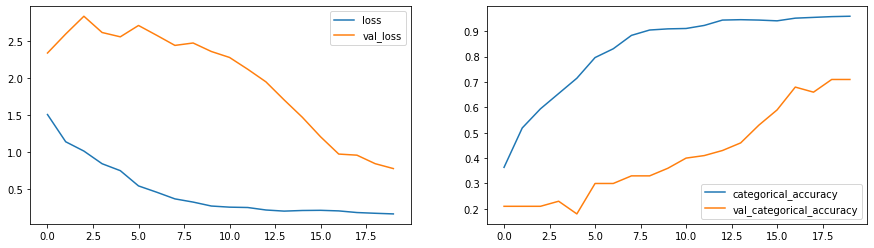

In [ ]:
conv_gru.train_model(conv_gru_model,model_name="conv_gru",model_type="CNN_GRU")
conv_gru.plot_model()

***PLEASE SCROLL THE WHOLE OUTPUT OF THE TRAINING CELL TO SEE THE GRAPHS OF LOSS AND ACCURACY***

**Observations and Thoughts:**
1. We see loss: 0.1611 - categorical_accuracy: 0.9593 - val_loss: 0.7751 - val_categorical_accuracy: 0.7100
2. We see a training loss and validation loss less than 1
3. Accuracies are 95% and 71% which is a sign of overfitting
4. Lets increase dropout and increase batch size to see if it reduces overfitting.

**Model 11:** Conv2D+GRU 
- 20 frames to be sampled 
- batch size of 32 from 20 
- Images cropped to 120,120
- 128 dense neurons
- Epochs = 25
- dropout = 0.5
- gru cells = 128

In [ ]:
conv_gru2 = ConvGRU()
conv_gru2.initialize_path(project_folder_path)
conv_gru2.initialize_image_properties(image_height=120,image_width=120)
conv_gru2.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=25)
conv_gru2.initialize_modelparams()
conv_gru_model2=conv_gru2.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.5)
conv_gru_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 30, 30, 64)   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/25
20/21 [===========================>..] - ETA: 14s - loss: 1.8119 - categorical_accuracy: 0.2844

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 346s 17s/step - loss: 1.8065 - categorical_accuracy: 0.2866 - val_loss: 1.5709 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 1.57095, saving model to /content/drive/MyDrive/Project_dataconv_gru2_2021-10-2509_12_16.169836/model-00001-1.80645-0.28658-1.57095-0.31000.h5
Epoch 2/25
21/21 [==============================] - 72s 4s/step - loss: 1.5034 - categorical_accuracy: 0.3590 - val_loss: 1.8484 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.57095
Epoch 3/25
21/21 [==============================] - 69s 3s/step - loss: 1.3993 - categorical_accuracy: 0.4087 - val_loss: 2.0331 - val_categorical_accuracy: 0.1900

Epoch 00003: val_loss did not improve from 1.57095
Epoch 4/25
21/21 [==============================] - 67s 3s/step - loss: 1.2290 - categorical_accuracy: 0.4917 - val_loss: 1.9401 - val_categorical_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 1.57095
Epoch 5/25

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f9ffcf218c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 



Epoch 00017: val_loss did not improve from 1.57095

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 18/25
21/21 [==============================] - 69s 3s/step - loss: 0.6382 - categorical_accuracy: 0.7783 - val_loss: 2.2887 - val_categorical_accuracy: 0.3000

Epoch 00018: val_loss did not improve from 1.57095
Epoch 19/25
21/21 [==============================] - 69s 3s/step - loss: 0.7244 - categorical_accuracy: 0.7179 - val_loss: 2.1112 - val_categorical_accuracy: 0.3700

Epoch 00019: val_loss did not improve from 1.57095
Epoch 20/25
21/21 [==============================] - 66s 3s/step - loss: 0.6893 - categorical_accuracy: 0.7330 - val_loss: 2.2827 - val_categorical_accuracy: 0.3300

Epoch 00020: val_loss did not improve from 1.57095
Epoch 21/25
21/21 [==============================] - 68s 3s/step - loss: 0.7216 - categorical_accuracy: 0.7179 - val_loss: 2.0998 - val_categorical_accuracy: 0.3400

Epoch 00021: val_loss did not improve from 1.5709

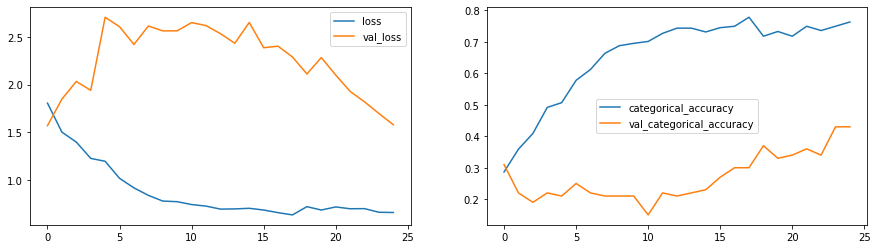

In [ ]:
conv_gru2.train_model(conv_gru_model2,model_name="conv_gru2",model_type="CNN_GRU")
conv_gru2.plot_model()

**Observations and Thoughts:**
1. Increasing the batch size didnot help and also increased the overfitting by a large extent
2. The models accuracy on validation decreased from 71 to 43%.
3. Instead of working on scratch models here, lets kick in with **transfer learning** for better image representation.
4. Lets now try to use transfer learning with MobileNet which is known to be the most prominent set of weights for light weight applications

**Model 12:** MobileNet+GRU 
- 20 frames to be sampled 
- batch size of 32 
- Images cropped to 120,120
- 128 dense neurons
- Epochs = 25
- dropout = 0.5
- gru cells = 128

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class ConvGRU_Transfer(ModelClass):
    
    def model_architecture(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


conv_gru_tl = ConvGRU_Transfer()
conv_gru_tl.initialize_path(project_folder_path)
conv_gru_tl.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=25)
conv_gru_tl.initialize_modelparams()
conv_gru_model_tl=conv_gru_tl.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.5)
conv_gru_model_tl.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/25
20/21 [===========================>..] - ETA: 2s - loss: 1.7800 - categorical_accuracy: 0.3031

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 76s 4s/step - loss: 1.7638 - categorical_accuracy: 0.3122 - val_loss: 1.3632 - val_categorical_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 1.36315, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl_2021-10-2509_55_35.484830/model-00001-1.76384-0.31222-1.36315-0.44000.h5
Epoch 2/25
21/21 [==============================] - 71s 4s/step - loss: 1.2791 - categorical_accuracy: 0.4766 - val_loss: 1.0767 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss improved from 1.36315 to 1.07669, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl_2021-10-2509_55_35.484830/model-00002-1.27911-0.47662-1.07669-0.59000.h5
Epoch 3/25
21/21 [==============================] - 70s 4s/step - loss: 1.0008 - categorical_accuracy: 0.6003 - val_loss: 0.8704 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss improved from 1.07669 to 0.87045, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl_2021-10-2509_55_3

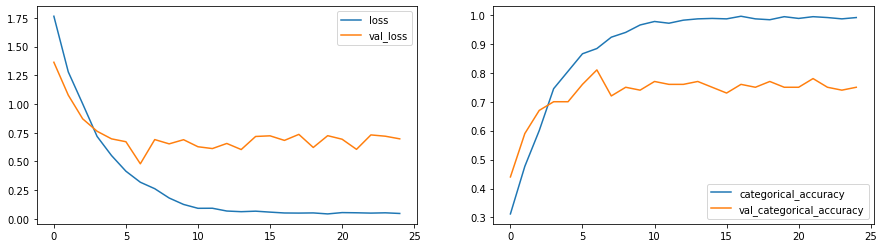

In [ ]:
conv_gru_tl.train_model(conv_gru_model_tl,model_name="conv_gru_tl",model_type="CNN_GRU")
conv_gru_tl.plot_model()

**Observations and Thoughts:**
1. The best epoch was the 7th epoch with a validation accuracy of 81% , Categorical accuracy of 88.39% , Validation loss of 0.47, categorical loss of 0.31
2. lets push the accuravy by decreasing batch size & dropout and increasing frames to sample

**Model 13:** MobileNet+GRU 
- 25 frames to be sampled 
- batch size of 16 
- Images cropped to 120,120
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128

In [ ]:
conv_gru_tl2 = ConvGRU_Transfer()
conv_gru_tl2.initialize_path(project_folder_path)
conv_gru_tl2.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl2.initialize_hyperparams(frames_to_sample=25,batch_size=16,num_epochs=25)
conv_gru_tl2.initialize_modelparams()
conv_gru_model_tl2=conv_gru_tl2.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_84 (TimeDis (None, 25, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_85 (TimeDis (None, 25, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_86 (TimeDis (None, 25, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_87 (TimeDis (None, 25, 1024)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/25
41/42 [============================>.] - ETA: 17s - loss: 1.3717 - categorical_accuracy: 0.4116

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 828s 20s/step - loss: 1.3708 - categorical_accuracy: 0.4103 - val_loss: 0.9395 - val_categorical_accuracy: 0.6800

Epoch 00001: val_loss improved from inf to 0.93945, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl2_2021-10-2510_45_41.527725/model-00001-1.37078-0.41026-0.93945-0.68000.h5
Epoch 2/25
42/42 [==============================] - 84s 2s/step - loss: 0.6279 - categorical_accuracy: 0.7783 - val_loss: 0.7852 - val_categorical_accuracy: 0.7000

Epoch 00002: val_loss improved from 0.93945 to 0.78521, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl2_2021-10-2510_45_41.527725/model-00002-0.62788-0.77828-0.78521-0.70000.h5
Epoch 3/25
42/42 [==============================] - 84s 2s/step - loss: 0.3047 - categorical_accuracy: 0.9110 - val_loss: 0.6654 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss improved from 0.78521 to 0.66545, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl2_2021-10-2510

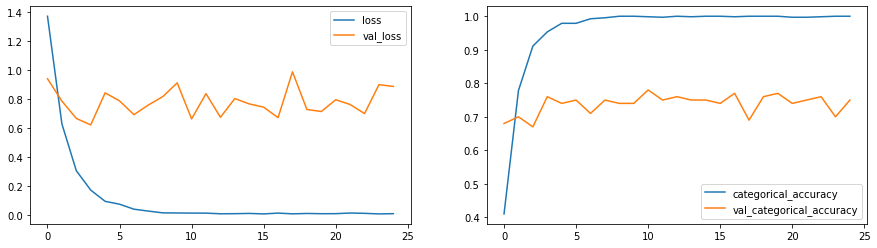

In [ ]:
conv_gru_tl2.train_model(conv_gru_model_tl2,model_name="conv_gru_tl2",model_type="CNN_GRU")
conv_gru_tl2.plot_model()

**Observations and Thoughts:**
1. This just increased the overfitting and no improvisation validation loss and accuracy
2. We see loss: 0.1710 - categorical_accuracy: 0.9532 - val_loss: 0.6208 - val_categorical_accuracy: 0.7600
3. Let's increase the batch size to 64 and decrease the frames to sample from 25 to 20 and see if it helps.

**Model 14:** MobileNet+GRU 
- 20 frames to be sampled 
- batch size of 64 
- Images cropped to 120,120
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128

In [ ]:
conv_gru_tl3 = ConvGRU_Transfer()
conv_gru_tl3.initialize_path(project_folder_path)
conv_gru_tl3.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl3.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
conv_gru_tl3.initialize_modelparams()
conv_gru_model_tl3=conv_gru_tl3.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_88 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_89 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_90 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_91 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)             

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/25
 9/11 [=======================>......] - ETA: 10s - loss: 1.6096 - categorical_accuracy: 0.2899

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


11/11 [==============================] - 75s 7s/step - loss: 1.5718 - categorical_accuracy: 0.3137 - val_loss: 1.2144 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 1.21440, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl3_2021-10-2511_33_40.126860/model-00001-1.57179-0.31373-1.21440-0.51000.h5
Epoch 2/25
11/11 [==============================] - 67s 7s/step - loss: 0.8809 - categorical_accuracy: 0.6893 - val_loss: 0.9849 - val_categorical_accuracy: 0.5700

Epoch 00002: val_loss improved from 1.21440 to 0.98493, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl3_2021-10-2511_33_40.126860/model-00002-0.88087-0.68929-0.98493-0.57000.h5
Epoch 3/25
11/11 [==============================] - 70s 7s/step - loss: 0.5603 - categorical_accuracy: 0.8296 - val_loss: 0.8530 - val_categorical_accuracy: 0.6500

Epoch 00003: val_loss improved from 0.98493 to 0.85300, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl3_2021-10-2511_3

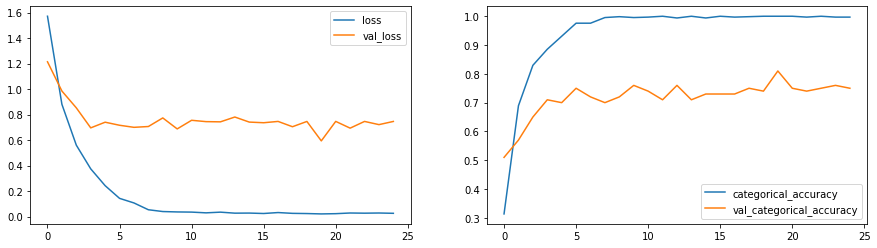

In [ ]:
conv_gru_tl3.train_model(conv_gru_model_tl3,model_name="conv_gru_tl3",model_type="CNN_GRU")
conv_gru_tl3.plot_model()

**Observations and Thoughts:**
1. We see loss: 0.0209 - categorical_accuracy: 1.0000 - val_loss: 0.5939 - val_categorical_accuracy: 0.8100
2. There is a slight decrease in the validation loss from 0.62 to 0.59 and increase in validation accuracy to 81% from 76%
3. Lets reduce the number of parameters by reducing the gru cells and dense neurons to 64 from 128 each

**Model 15:** MobileNet+GRU 
- 20 frames to be sampled 
- batch size of 64 
- Images cropped to 120,120
- 64 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 64





Reducing the number of neurons of gru and dense layer

In [ ]:
conv_gru_tl4 = ConvGRU_Transfer()
conv_gru_tl4.initialize_path(project_folder_path)
conv_gru_tl4.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl4.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
conv_gru_tl4.initialize_modelparams()
conv_gru_model_tl4=conv_gru_tl4.model_architecture(gru_cells=64,dense_neurons=64,dropout=0.25)
conv_gru_model_tl4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_92 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_93 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_94 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_95 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_10 (GRU)                 (None, 64)                209280    
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)              

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/25
 9/11 [=======================>......] - ETA: 11s - loss: 1.6662 - categorical_accuracy: 0.3160

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


11/11 [==============================] - 76s 7s/step - loss: 1.6249 - categorical_accuracy: 0.3288 - val_loss: 1.3705 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.37047, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl4_2021-10-2512_33_02.727289/model-00001-1.62488-0.32881-1.37047-0.40000.h5
Epoch 2/25
11/11 [==============================] - 67s 7s/step - loss: 1.1317 - categorical_accuracy: 0.5656 - val_loss: 1.2352 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss improved from 1.37047 to 1.23524, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl4_2021-10-2512_33_02.727289/model-00002-1.13169-0.56561-1.23524-0.49000.h5
Epoch 3/25
11/11 [==============================] - 69s 7s/step - loss: 0.8877 - categorical_accuracy: 0.6908 - val_loss: 1.0333 - val_categorical_accuracy: 0.5500

Epoch 00003: val_loss improved from 1.23524 to 1.03325, saving model to /content/drive/MyDrive/Project_dataconv_gru_tl4_2021-10-2512_3

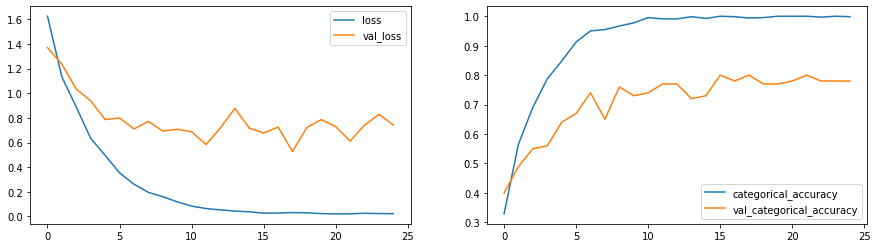

In [ ]:
conv_gru_tl4.train_model(conv_gru_model_tl4,model_name="conv_gru_tl4",model_type="CNN_GRU")
conv_gru_tl4.plot_model()

**Observations and Thoughts:**
1. We see loss: 0.0319 - categorical_accuracy: 0.9940 - val_loss: 0.5272 - val_categorical_accuracy: 0.8000
2. There is a slight decrease in the validation loss from 0.59 to 0.52
3. lets reduce the batch size to 8 and below configuration with previous increased dense and gru units of 128 , reduce the frames to 15

**Model 16:** MobileNet+GRU 
- 15 frames to be sampled 
- batch size of 8 
- Images cropped to 120,120
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128


In [ ]:
conv_gru_tl4_copy = ConvGRU_Transfer()
conv_gru_tl4_copy.initialize_path(project_folder_path)
conv_gru_tl4_copy.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl4_copy.initialize_hyperparams(frames_to_sample=15,batch_size=8,num_epochs=25)
conv_gru_tl4_copy.initialize_modelparams()
conv_gru_model_tl4_copy=conv_gru_tl4_copy.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl4_copy.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_12 (GRU)                 (None, 128)               443136    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [ ]:
conv_gru_tl4_copy.train_model(conv_gru_model_tl4_copy,model_name="conv_gru_tl4_copy",model_type="CNN_GRU")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/25
82/83 [============================>.] - ETA: 0s - loss: 1.4163 - categorical_accuracy: 0.4055

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


83/83 [==============================] - 48s 541ms/step - loss: 1.4159 - categorical_accuracy: 0.4027 - val_loss: 1.0122 - val_categorical_accuracy: 0.6200

Epoch 00001: val_loss improved from inf to 1.01224, saving model to /content/drive/MyDrive/conv_gru_tl4_copy_2021-10-2616_50_50.256153/model-00001-1.41591-0.40271-1.01224-0.62000.h5
Epoch 2/25
83/83 [==============================] - 43s 524ms/step - loss: 0.7221 - categorical_accuracy: 0.7225 - val_loss: 0.6544 - val_categorical_accuracy: 0.7400

Epoch 00002: val_loss improved from 1.01224 to 0.65438, saving model to /content/drive/MyDrive/conv_gru_tl4_copy_2021-10-2616_50_50.256153/model-00002-0.72205-0.72247-0.65438-0.74000.h5
Epoch 3/25
83/83 [==============================] - 43s 527ms/step - loss: 0.4037 - categorical_accuracy: 0.8733 - val_loss: 0.6949 - val_categorical_accuracy: 0.7400

Epoch 00003: val_loss did not improve from 0.65438
Epoch 4/25
83/83 [==============================] - 43s 525ms/step - loss: 0.1865 - cate

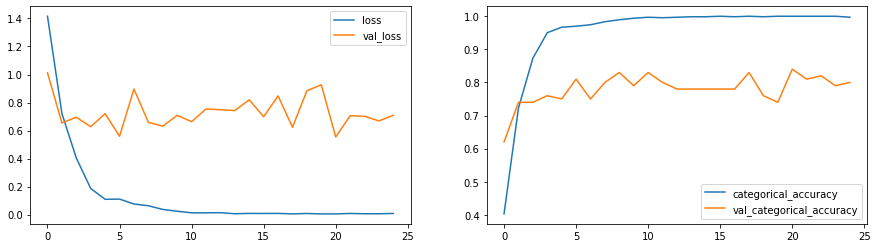

In [ ]:
conv_gru_tl4_copy.plot_model()

**Observations and Thoughts:**

- We see loss: 0.1109 - categorical_accuracy: 0.9698 - val_loss: 0.5595 - val_categorical_accuracy: 0.8100
- There is a slight increase in the validation loss from 0.52 to 0.56
- Reduced overfitting from 99:80 to 96:81 , train:val accuracy.
- Lets try training on whole mobilenet model with the same parameters


**Model 17:** MobileNet(on all the layers)+GRU

- 15 frames to be sampled
- batch size of 8
- Images cropped to 120,120
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128



In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class ConvGRU_Transfer_NoWeights(ModelClass):
    
    def model_architecture(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = True
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

conv_gru_tl4_now = ConvGRU_Transfer_NoWeights()
conv_gru_tl4_now.initialize_path(project_folder_path)
conv_gru_tl4_now.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl4_now.initialize_hyperparams(frames_to_sample=15,batch_size=8,num_epochs=25)
conv_gru_tl4_now.initialize_modelparams()
conv_gru_model_tl4_now=conv_gru_tl4_now.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl4_now.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_41 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_14 (GRU)                 (None, 128)               443136    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)             

In [ ]:
conv_gru_tl4_now.train_model(conv_gru_model_tl4_now,model_name="conv_gru_tl4_now",model_type="CNN_GRU")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/25
81/83 [============================>.] - ETA: 1s - loss: 1.1651 - categorical_accuracy: 0.5309

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


83/83 [==============================] - 61s 643ms/step - loss: 1.1508 - categorical_accuracy: 0.5370 - val_loss: 0.6826 - val_categorical_accuracy: 0.6900

Epoch 00001: val_loss improved from inf to 0.68256, saving model to /content/drive/MyDrive/conv_gru_tl4_now_2021-10-2617_37_49.157949/model-00001-1.15076-0.53695-0.68256-0.69000.h5
Epoch 2/25
83/83 [==============================] - 51s 611ms/step - loss: 0.6136 - categorical_accuracy: 0.7632 - val_loss: 0.4452 - val_categorical_accuracy: 0.8000

Epoch 00002: val_loss improved from 0.68256 to 0.44522, saving model to /content/drive/MyDrive/conv_gru_tl4_now_2021-10-2617_37_49.157949/model-00002-0.61364-0.76320-0.44522-0.80000.h5
Epoch 3/25
83/83 [==============================] - 51s 617ms/step - loss: 0.4028 - categorical_accuracy: 0.8582 - val_loss: 0.2814 - val_categorical_accuracy: 0.8900

Epoch 00003: val_loss improved from 0.44522 to 0.28142, saving model to /content/drive/MyDrive/conv_gru_tl4_now_2021-10-2617_37_49.157949/mod

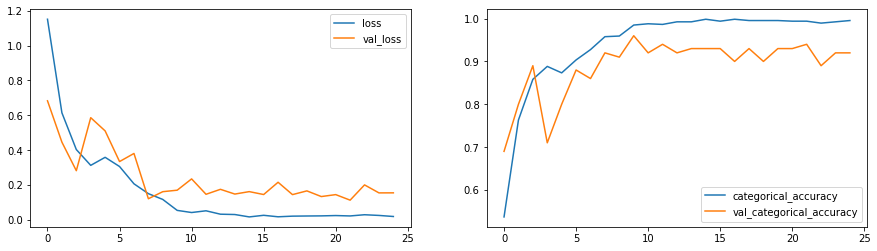

In [ ]:
conv_gru_tl4_now.plot_model()

**Observations and Thoughts:**

- loss: 0.0216 - categorical_accuracy: 0.9940 - val_loss: 0.1122 - val_categorical_accuracy: 0.9400
- This is the best model till now with the highest validation accuracy of 94% and least validation loss of just 0.1122

**Which Model to Choose??**
We have got a tradeoff between two models:
1. Model3 -> Conv3D -> Epoch25th Model -> Validation accuracy 86% -> validation loss 0.46 -> Model Size 14MB -> Trainable Params 11,55,397

2. Model17 -> MobileNet(with complete training over all the layers) + GRU -> epoch 22nd Model -> Validation accuracy 94% -> validation loss 0.1122 -> Model Size 44MB -> 36,93,253

**We select the second one which is the MobileNet+GRU for the following reasons:**
- The validation loss is way lesser ~0.1122 than the conv3D Model with 0.46
- The accuracy is 94% which is remarkable than Conv3D model with 86%
- Trainable params are almost thrice but a 44MB model is not a huge model when compared to CNNs which end up in GBs.
- Models in MBs are easily deployable on smart devices.

## Summary of Experiments

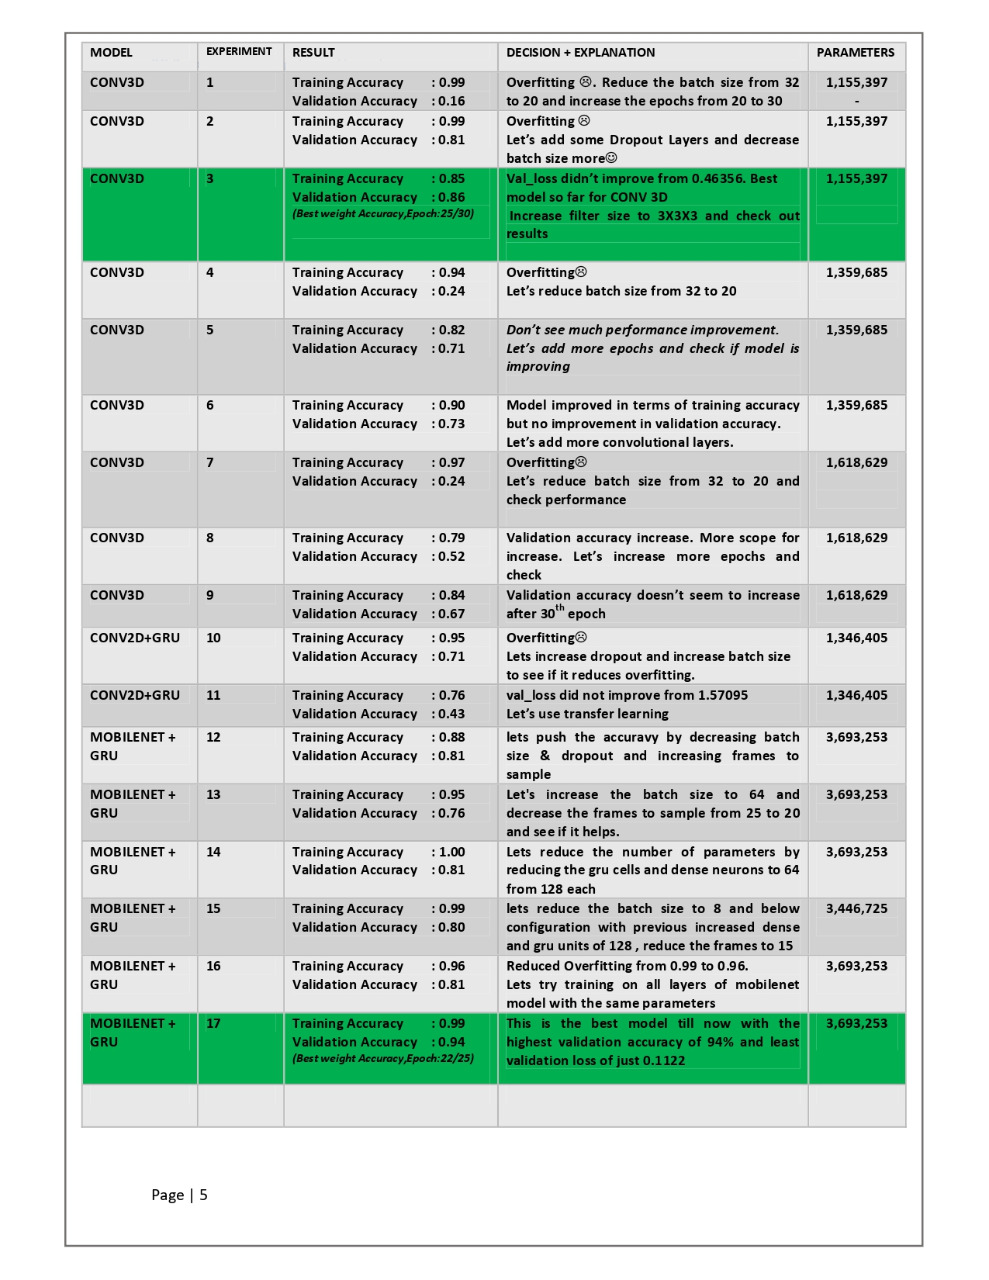

###Testing the model on a random batch in validation set

In [ ]:
# loading the model
import time
from keras.models import load_model
model = load_model('/content/drive/MyDrive/conv_gru_tl4_now_2021-10-2617_37_49.157949/Mobilenet_NoW_model-00022-0.02159-0.99397-0.11221-0.94000.h5')

In [ ]:
test_generator=ConvGRU_Transfer_NoWeights()
test_generator.initialize_path(project_folder_path)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=15,batch_size=8,num_epochs=25)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,model_type="Conv_GRU")
batch_data, batch_labels=next(g)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [ ]:
batch_labels. ##true labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)) ## predicted labels

[1 2 0 1 4 2 2 3]


**Why not test on our own video?**
- We have recorded few videos of ourselves with thumbsup , thumbsdown and rightSwipe and stored in a location. 
- The below code will process the videos and split them into frames and store them. 
- Further we have a generator which will create a representation for these videos and then test with the actual values. 
- For these three videos we have created a test.csv file with the actual label values like in val.csv

In [ ]:
import cv2
import os
for video in os.listdir('/content/drive/MyDrive/Videosforgesturerecognition'):
  capture = cv2.VideoCapture('/content/drive/MyDrive/Videosforgesturerecognition/'+video)
  
  frameNr = 0
  if video.split(".")[0] not in os.listdir('/content/drive/MyDrive/GR_FramedVideos'):
    os.mkdir('/content/drive/MyDrive/GR_FramedVideos/'+video.split(".")[0])
  while (True):

      success, frame = capture.read()
  
      if success:
          frame = cv2.resize(frame,(120,120))
          frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
          cv2.imwrite('/content/drive/MyDrive/GR_FramedVideos/'+video.split(".")[0]+'/frame_'+str(frameNr)+'.jpg', frame)
  
      else:
          break
  
      frameNr = frameNr+1
  
  capture.release()

In [ ]:
##modifying the generator to accomodate our own video with a batch size of 1 as we want to test on our own video

def test_generator(source_path, folder_list, model_type = "Conv3D",frames_to_sample=15,image_height=120,image_width=120,batch_size=1,channels=3,num_classes=5):
      if model_type == "Conv3D":
        img_idx = [rn.randint(0, total_frames-1) for i in range(frames_to_sample)] #create a list of image numbers you want to use for a particular video
      else:
        img_idx = [i for i in range(frames_to_sample)] ## CNN+GRU
      # print(img_idx)
      while True:
          t = np.random.permutation(folder_list)
          num_batches = len(folder_list)//batch_size # calculate the number of batches
          for batch_no in range(num_batches): # we iterate over the number of batches
              batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
              batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
              for folder in range(batch_size): # iterate over the batch_size
                  imgs = os.listdir(source_path+'/'+ t[folder + (batch_no*batch_size)].split(',')[0]) # read all the images in the folder
                  # print("imgs: ",imgs)
                  for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                      image = imread(source_path+'/'+ t[folder + (batch_no*batch_size)].strip().split(',')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape == (360,360,3): ###if images are of 360 x 360
                        image = imresize(image,(image_height,image_width,channels))
                      else:
                        image = image[:,(image.shape[0] - image_height ) // 2 : image.shape[0] - (image.shape[0] - image_height ) // 2] ### if lower quality just centre crop
                      #crop the images and resize them. Note that the images are of 2 different shape 
                      #and the conv3D will throw error if the inputs in a batch have different shapes
                      

                      batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                      
                  batch_labels[folder, int(t[folder + (batch_no*batch_size)].strip().split(',')[2])] = 1
              yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
test_gen = test_generator(
    source_path = "/content/drive/MyDrive/GR_FramedVideos",
    folder_list = np.random.permutation(open("/content/drive/MyDrive/test.csv").readlines()),
    model_type = "CNN_GRU",
    frames_to_sample=15
)

In [ ]:
##generate a video representation
batch_data, batch_labels=next(test_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


In [ ]:
batch_labels ##true label is one hot at index 3

array([[0., 0., 0., 1., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)) ## predicted labels

[3]


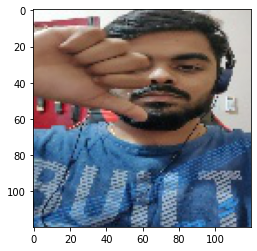

In [ ]:
## lets look at an image from this video
plt.imshow(batch_data[0][13])

**As we can see that the index - 3 is for ThumbsDown_new and the video was actually thumbs down. Our final model has done a decent job in prediction!**